標準RNNを使いSpamデータセットをスパムと判断できるか実践してみる。
（埋め込みテキストから入力RNNシーケンスをとり、RNNの最後の出力としてスパムかどうか判定する予測値（0 or 1）を扱う）

In [2]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

sess = tf.Session()

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# RNNパラメーターの設定
epochs = 50
batch_size = 250
max_sequence_length = 25 #調べるテキストの最大の長さ
rnn_size = 10 #ノード数
embedding_size = 50 #サイズが50のトレーニング可能なベクトル
min_word_frequency = 10 #10回以上出現する単語のみを考慮
learning_rate = 0.0005 #ドロップアウト確率（セルを無視する確率）
dropout_keep_prob = tf.placeholder(tf.float32)

In [4]:
# Spamデータセットのテキストデータを取得
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    # データの書式設定
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # データをテキストファイルに保存
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # テキストファイルからデータを読み込む
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [5]:
# 語彙のサイズを減らすために、入力テキストから特殊文字と余分な空白を取り除き、英字をすべて小文字にする
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string
 
text_data_train = [clean_text(x) for x in text_data_train]

In [7]:
# テキストをインデックスのリストに変換する（TensorFlowに適応させるため）
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

In [8]:
# データをシャッフルした上で分割する
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

In [11]:
# データを80:20でトレーニングセットとテストセットに分割する(今回はハイパーパラメータのチューニングは行わない)
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [12]:
# プレースホルダの設定
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [13]:
# X入力データの埋め込み行列と埋め込み探索演算を作成する
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [14]:
# モデルの設定
if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [15]:
# RNNシーケンスの出力を取得
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [16]:
# 予測を終了するには、全結合層を使ってrnn_sizeの大きさの出力を2カテゴリの出力に変換する
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

In [17]:
# 損失関数を設定する
# ソフトマックス関数を使用する場合は、目的値を整数型のインデックスに変換、ロジットを浮動小数点数に変換しなくてはならない
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

In [18]:
# 正解関数の設定
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

In [20]:
# 最適化関数を宣言し、モデルの変数を初期化する
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [21]:
# トレーニングの開始（過学習を防ぐために、エポックごとにでデータをシャッフルする）
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# トレーニングを開始
for epoch in range(epochs):

    # トレーニンングデータをシャッフル
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # トレーニンングデータを選択
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # トレーニングステップを実行
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # トレーニングの損失値と正解率を計算
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # 評価ステップを実行
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.7, Test Acc: 0.17
Epoch: 2, Test Loss: 0.67, Test Acc: 0.83
Epoch: 3, Test Loss: 0.62, Test Acc: 0.83
Epoch: 4, Test Loss: 0.58, Test Acc: 0.84
Epoch: 5, Test Loss: 0.53, Test Acc: 0.84
Epoch: 6, Test Loss: 0.48, Test Acc: 0.85
Epoch: 7, Test Loss: 0.45, Test Acc: 0.85
Epoch: 8, Test Loss: 0.43, Test Acc: 0.85
Epoch: 9, Test Loss: 0.41, Test Acc: 0.86
Epoch: 10, Test Loss: 0.4, Test Acc: 0.86
Epoch: 11, Test Loss: 0.4, Test Acc: 0.87
Epoch: 12, Test Loss: 0.39, Test Acc: 0.87
Epoch: 13, Test Loss: 0.39, Test Acc: 0.87
Epoch: 14, Test Loss: 0.39, Test Acc: 0.88
Epoch: 15, Test Loss: 0.38, Test Acc: 0.87
Epoch: 16, Test Loss: 0.38, Test Acc: 0.87
Epoch: 17, Test Loss: 0.38, Test Acc: 0.87
Epoch: 18, Test Loss: 0.38, Test Acc: 0.87
Epoch: 19, Test Loss: 0.38, Test Acc: 0.87
Epoch: 20, Test Loss: 0.37, Test Acc: 0.87
Epoch: 21, Test Loss: 0.37, Test Acc: 0.87
Epoch: 22, Test Loss: 0.37, Test Acc: 0.87
Epoch: 23, Test Loss: 0.37, Test Acc: 0.87
Epoch: 24, Test Loss: 0

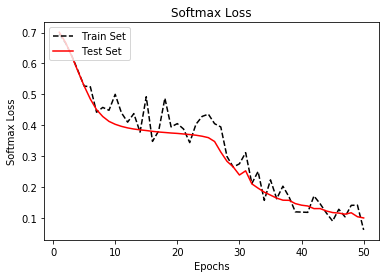

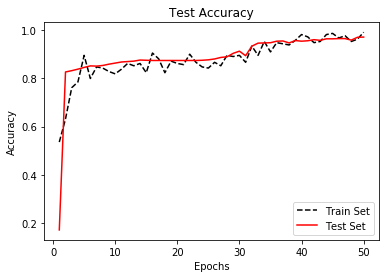

In [22]:
# トレーニングセットとテストセットの損失値と正解率をプロット
%matplotlib inline

# 損失血をプロット
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# 正解率をプロット
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

テストデータで約97%の正解率を達成！！
シーケンシャルデータの場合は、トレーニングセットを複数回処理することが重要！
また、シーケンシャルでないデータで試してみることもオススメ
